Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm
import ast
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


Evaluating the first round of training of the ResNet 50 Model 
- The model intially struggles with class imbalance since there are low accuracy rates with a bias towards classes with more data such as Normal, Other and Diabetes. 
- Training accuracy improved over time but validation accuracy lagged suggesting overfitting. Loss decreased steadily, yet training and validation loss diverged.
- Model frequently misclassified minority classes (e.g., Diabetes as Normal). Therefore there is a need to implement class balance correction techniques for better model generalisation and performance. 

Below images related to these mentioned issues are displayed:


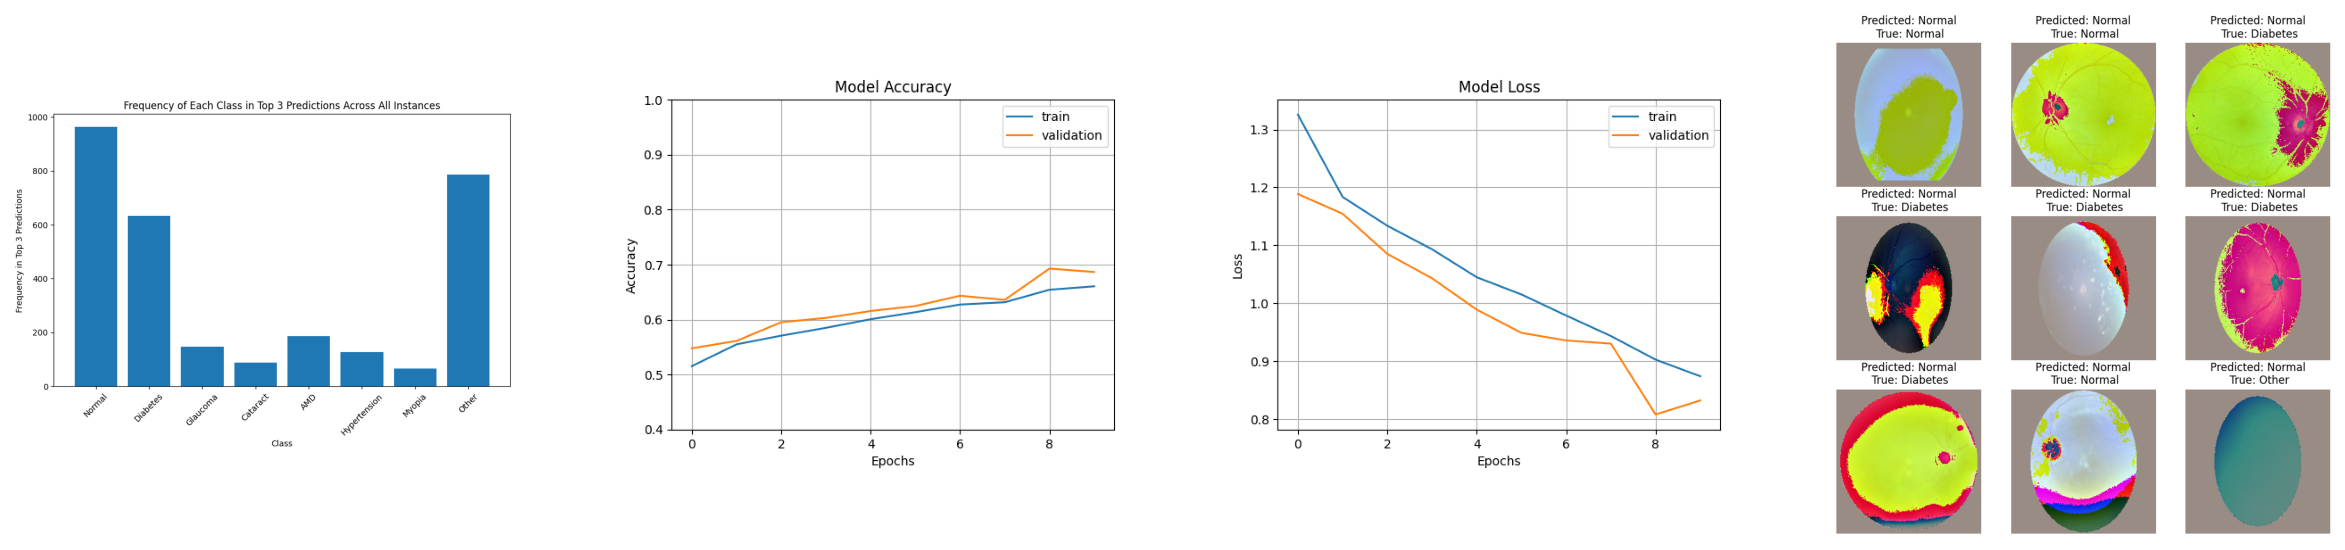

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(30,10))

pred_graph = plt.imread('resnet_50_model/intial-eval/top3predictions.png')
axs[0].imshow(pred_graph)
axs[0].axis('off')

model_acc = plt.imread('resnet_50_model/intial-eval/modelacc.png')
axs[1].imshow(model_acc)
axs[1].axis('off')

model_loss = plt.imread('resnet_50_model/intial-eval/modelloss.png')
axs[2].imshow(model_loss)
axs[2].axis('off')

test_pred = plt.imread('resnet_50_model/intial-eval/TestPred.png')
axs[3].imshow(test_pred)
axs[3].axis('off')

plt.show()



Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H, M, and O are minority classes since they have low image samples, causing class imbalance. 

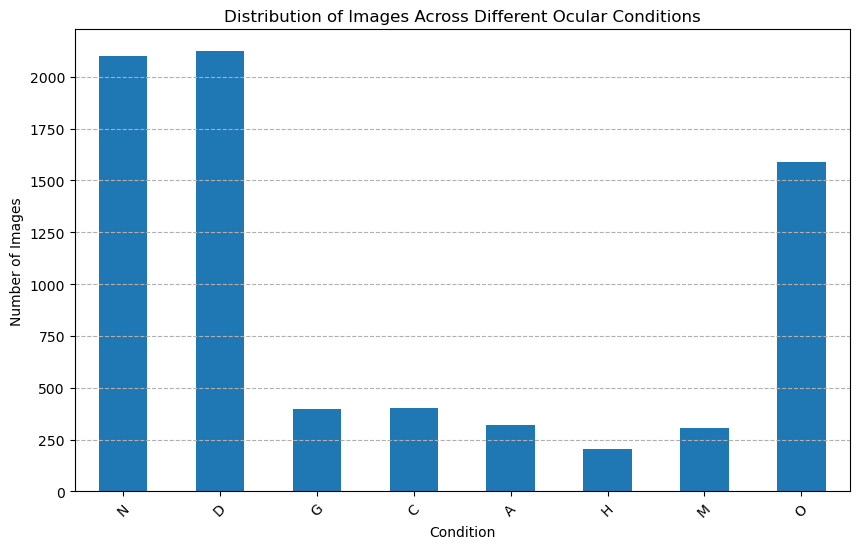

In [4]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [5]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


Loading and Visualising the Minority Class Dataset 
- This dataset will include images from the training data that are classified as any of the minority classes -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

In [9]:
images_path = 'dataset/ODIR-5K/Training Images/'  
minority_classes = ['G', 'C', 'A', 'H', 'M']

# Map of minority class labels to their corresponding indices
minority_class_indices = {cls: i for i, cls in enumerate(minority_classes)}

# Filter the dataframe for rows where the target column indicates a minority class
# Here we use a lambda function to check if any of the minority class indices has a 1 in the target list
df_data_minority = df_data[df_data['target'].apply(lambda target: any([target[minority_class_indices[cls]] == 1 for cls in minority_classes]))]

# Initialize lists to store the images and labels
minority_images = []
minority_labels = []

augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=50,  
    fill_mode='nearest' 
)

minority_class_counts= df_data[['G', 'C', 'A', 'H', 'M', 'O']].sum()
print(minority_class_counts)

# Count images per class and initialize the dictionary
class_image_counts = {cls: 0 for cls in minority_classes}

def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        
        return img, label
    return None, None

def handle_minority_image_result(result):
     img, label = result
     if img is not None and label is not None:
          # Augment the image and label
          for _ in range(5):  # Augment each image 5 times
               augmented_img = augmentation.random_transform(img)
               minority_images.append(augmented_img)
               minority_labels.append(label)
          # Update the class image count
          for i, cls in enumerate(minority_classes):
               if label[i] == 1:
                    class_image_counts[cls] += 5



# Use ThreadPoolExecutor to load and process images that match minority_classes
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in tqdm(df_data_minority.iterrows(), total=df_data.shape[0], desc='Processing images'):
        # For each minority class, check if the condition is present for either eye
        for minority_class in minority_classes:
            if minority_class in row and row[minority_class] == 1:  # Check if the condition is marked for this row
                # Check each eye and process the image if the condition is present
                if 'Left-Fundus' in row and row[minority_class] == 1:
                    left_image_path = os.path.join(images_path, row['Left-Fundus'])
                    # Pass the minority class as the label
                    futures.append(executor.submit(load_process_minority_image, left_image_path, row['target']))
                if 'Right-Fundus' in row and row[minority_class] == 1:
                    right_image_path = os.path.join(images_path, row['Right-Fundus'])
                    # Pass the minority class as the label
                    futures.append(executor.submit(load_process_minority_image, right_image_path, row['target']))
    
    
    for future in tqdm(futures, desc='Collecting results'):
        handle_minority_image_result(future.result())

# Convert to NumPy arrays
minority_images = np.array(minority_images)
minority_labels = np.array(minority_labels)

# Print out the class counts to verify
print("Image counts per class after augmentation:")
for cls in minority_classes:
    print(f"{cls}: {class_image_counts[cls]}")

G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


Processing images:  85%|████████▌ | 5452/6392 [00:00<00:00, 8991.00it/s] 


Image counts per class after augmentation:
G: 5700
C: 4510
A: 3530
H: 3290
M: 3060
O: 1580


c:\Users\duwak\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


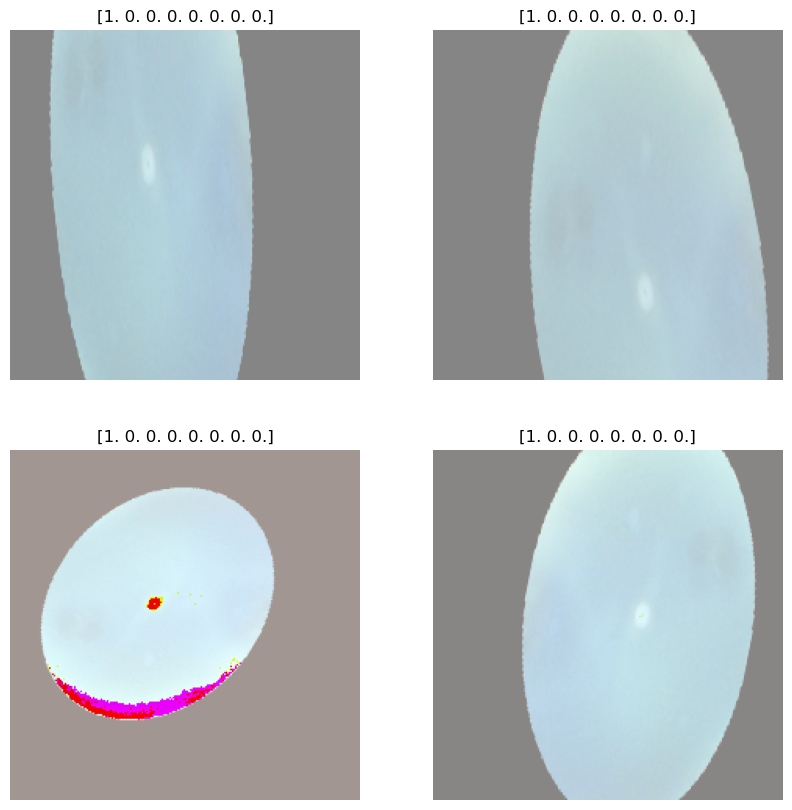

In [10]:
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(minority_images[i].astype('uint8'))
    plt.title(minority_labels[i])
    plt.axis('off')

plt.show()

Loading and Visualising the majority classes 

In [11]:
images_path = 'dataset/ODIR-5K/Training Images/'

majority_classes = ['N', 'D']

# Map of majority class labels to their corresponding indices
majority_class_indices = {cls: i for i, cls in enumerate(majority_classes)}

# Filter the dataframe for rows where the target column indicates a majority class
# Here we use a lambda function to check if any of the majority class indices has a 1 in the target list
df_data_majority = df_data[df_data['target'].apply(lambda x: any(string_to_float_list(x)[i] for i in majority_class_indices.values()))]

# Initialize lists to store the images and labels
majority_images = []
majority_labels = []

# Load and process the images

def load_process_majority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        label_list = string_to_float_list(label)
        label = tf.convert_to_tensor(label_list, dtype=tf.float32)
        return img, label
    return None, None

def handle_majority_image_result(result):
    img, label = result
    if img is not None and label is not None:
        majority_images.append(img)
        majority_labels.append(label)

# Use ThreadPoolExecutor to load and process images that match majority_classes  
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in tqdm(df_data_majority.iterrows(), total=df_data.shape[0], desc='Processing images'):
        # For each majority class, check if the condition is present for either eye
        for majority_class in majority_classes:
            if majority_class in row and row[majority_class] == 1:  # Check if the condition is marked for this row
                # Check each eye and process the image if the condition is present
                if 'Left-Fundus' in row and row[majority_class] == 1:
                    left_image_path = os.path.join(images_path, row['Left-Fundus'])
                    # Pass the majority class as the label
                    futures.append(executor.submit(load_process_majority_image, left_image_path, row['target']))
                if 'Right-Fundus' in row and row[majority_class] == 1:
                    right_image_path = os.path.join(images_path, row['Right-Fundus'])
                    # Pass the majority class as the label
                    futures.append(executor.submit(load_process_majority_image, right_image_path, row['target']))
    
    for future in tqdm(futures, desc='Collecting results'):
        handle_majority_image_result(future.result())


# Convert to NumPy arrays
majority_images = np.array(majority_images)
majority_labels = np.array(majority_labels)


Processing images:  70%|███████   | 4481/6392 [00:00<00:00, 8703.40it/s] 


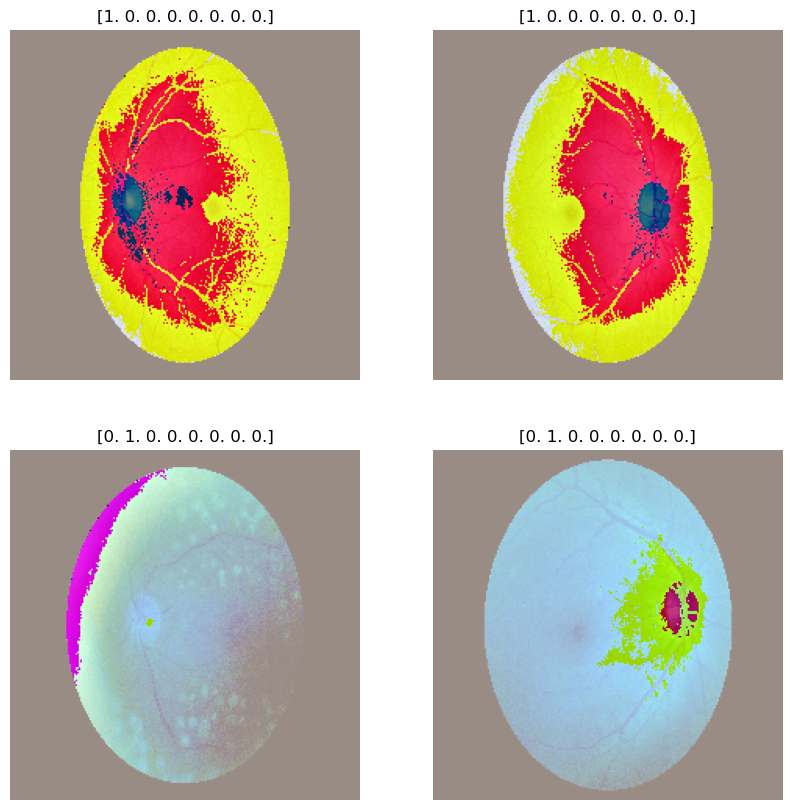

In [12]:

# Plot the images
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(majority_images[i].astype('uint8'))
    plt.title(majority_labels[i])
    plt.axis('off')
    

In [25]:
# join the minority and majority images and labels
images = np.vstack([minority_images, majority_images])
labels = np.vstack([minority_labels, majority_labels])

MemoryError: Unable to allocate 16.6 GiB for an array with shape (29592, 224, 224, 3) and data type float32

Preparing augmentated data for training
- Splitting the augmented minority data into training and validation sets. 

In [24]:

# Create a tf.data.Dataset
image_ds = tf.data.Dataset.from_tensor_slices((images, labels))

# Shuffle the dataset
image_ds = image_ds.shuffle(buffer_size=len(images))

# Split the dataset into training and validation sets
train_size = int(0.8 * len(images))
train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size)

# Batch the datasets
batch_size = 16
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# Prefetch the datasets
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)


MemoryError: Unable to allocate 16.6 GiB for an array with shape (29592, 224, 224, 3) and data type float32

In [20]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))

TypeError: The dataset length is unknown.

Visualising Training and Validation Data 

Training dataset
(32, 224, 224, 3)
(32, 8)


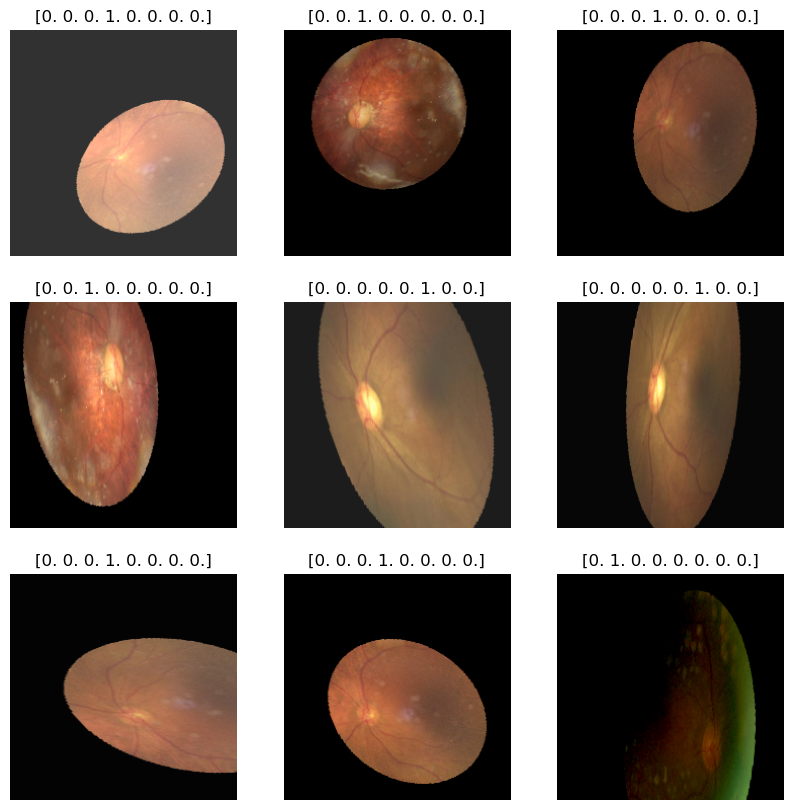

In [ ]:
print("Training dataset")
for images, labels in train_dataset.take(1):
    print(images.shape)
    print(labels.shape)


# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

Validation dataset
(32, 224, 224, 3)
(32, 8)


c:\Users\duwak\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


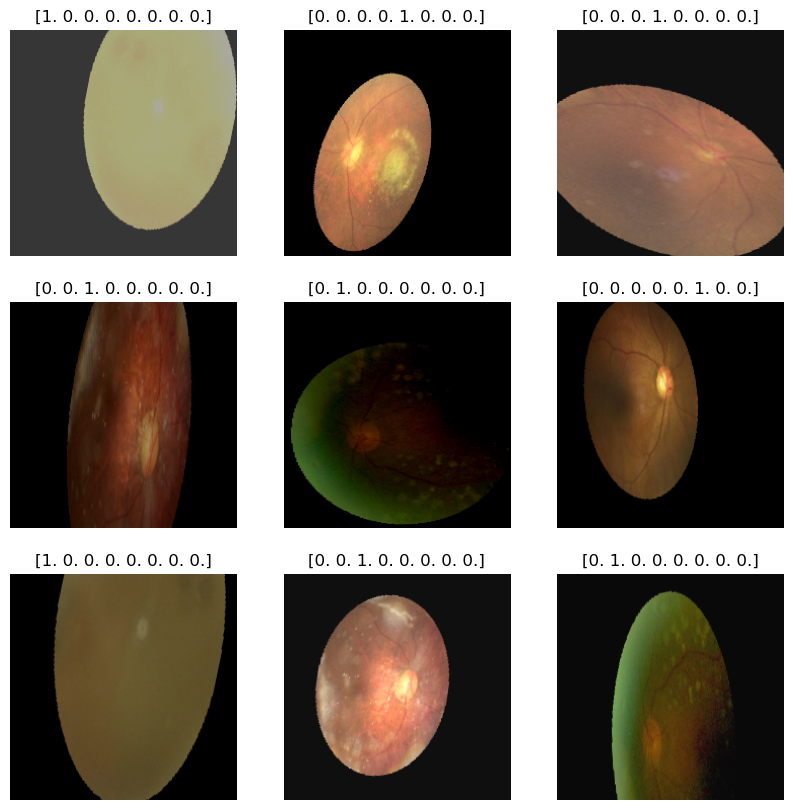

In [ ]:
print("Validation dataset")
for images, labels in val_dataset.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

Training the model

In [ ]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

resnet_50_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24640904 (94.00 MB)
Trainable params: 1053192 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 10
history = resnet_50_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Evaluating Model 

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Loading Test Data 

In [ ]:
def parse_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)

    return image

In [ ]:
from pathlib import Path


data_dir = Path('dataset/ODIR-5K/')
test_dataset = list(data_dir.glob('Testing Images/*'))


test_dataset = [str(path) for path in test_dataset]
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(parse_image)


# Now you can batch, shuffle, and prefetch the dataset as needed
test_dataset = test_dataset.batch(32)  # batching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # prefetching


# Visualize the data
plt.figure(figsize=(10,10))

for i, image in enumerate(test_dataset.take(4)):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(image[0] / 255)
    plt.axis('off')



In [ ]:
print("size of test dataset: ", len(test_dataset))    

Making Predictions


In [ ]:
# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_dataset)

predictions = resnet_50_model.predict(test_dataset)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Plot the first 9 images, their predicted labels, and the true labels
output_class=class_labels[np.argmax(predicted_classes[i])]
plt.figure(figsize=(10, 10))

for i, image in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0] / 255)
    plt.title("Predicted: {}\n True: {}".format(output_class, class_labels[np.argmax(labels[i])]))
    plt.axis("off")

In [ ]:

# Get the class with the highest probability
pred_class = np.argmax(pred)
print(pred_class)

# Get the class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
class_labels[pred_class]

# Get the top 3 class labels
top3_class_indices = pred[0].argsort()[-3:][::-1]
top3_class_indices

# Get the top 3 class labels
top3_class_labels = [class_labels[i] for i in top3_class_indices]
top3_class_labels

# Get the top 3 class probabilities
top3_class_probabilities = pred[0][top3_class_indices]
top3_class_probabilities

# Visualize the top 3 class labels and their probabilities
plt.bar(top3_class_labels, top3_class_probabilities)
plt.ylabel('Probability')
plt.xlabel('Class')
plt.title('Top 3 Predictions')
plt.show()

In [ ]:
# Save the model
resnet_50_model.save('resnet_50_model')